# Plotting the Forbidden Region
We'll show how to compute the Jacobi Constant and use it to constrain our system

In [6]:
@time using ThreeBodyProblem
@time using DifferentialEquations.OrdinaryDiffEq
@time using Plots

  0.000115 seconds (99 allocations: 7.859 KiB)
  0.000073 seconds (99 allocations: 7.844 KiB)
  0.000041 seconds (99 allocations: 7.844 KiB)


### We'll work in the Earth-Moon system because the mass parameter is relatively large

In [7]:
sys = earth_moon() # earth-moon system

System(Body(5.97237e24, 6371.0084, 1.495978976276167e8, 3.155814910224e7, "Earth", :blue), Body(7.3457905697975825e22, 1737.5, 384400.0, 2.3606208e6, "Moon", :grey), 384400.0, 2.3606208e6, 398613.89090999996, 4902.801, 0.012150181388514944, 6371.0084, 1737.5, 398613.89090999996, 4902.801, 0.012150181388514944, 6371.0084, 1737.5, 6.045827905697976e24, 384400.0, 375704.4690855444, 1.0231446033517257, 2.7232697173979187e-6, "Earth/Moon")

## Augmented Potential Ω
A potential function depends only on position. At the center of the planets, the potential function is infinite (i.e. has a singularity). In the rotating frame, we have to add terms to account for the centrifugal force, giving us
\begin{align}
\Omega = \frac{(x^2 + y^2)}{2}n^2 + \frac{1-\mu}{r_1} + \frac{μ}{r_2}\\
\end{align}
where
\begin{align}
r_1 = \sqrt{(x+\mu)^2 + y^2 + z^2}\\
r_2 = \sqrt{(x-1+\mu)^2 + y^2 + z^2}.
\end{align}
Note that we define the mean motion $n=1$ in the normalized coordinates.

Let's compute the augmented potential on a grid of the CR3BP.

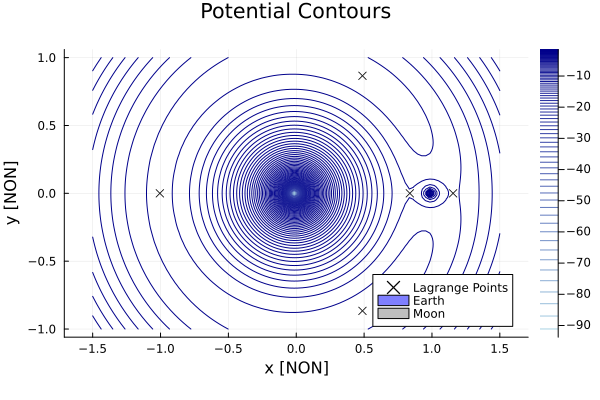

In [8]:
N = 100 # using 100 sample points in each direction
X = range(-1.5,1.5,length=N) # range of x values
Y = range(-1,1,length=N) # range of y values

p_contour = plot() # plot for potential contours
f(x,y) = -computeΩ([x,y,0,0,0,0], sys) # negative effective potential (also -computeUeff(r, sys))

plot!(p_contour, sys, title="Potential Contours", xlabel="x [NON]", ylabel="y [NON]", legend=:bottomright) # plot the system

levels = -exp10.(range(2,0,length=100)); # levels for contour plot
contour!(p_contour,X,Y,f,levels=levels,fill=false,c = :blues) # plot the contours

We can see that L1 and L2 lie at saddle points. L3 also is at a saddle point although it is less apparent.

## Jacobi Constant
In the CR3BP there is only one conserved quantity, the Jacobi constant C.
\begin{align}
C &= (x^2 + y^2) + 2\frac{1-\mu}{r_1} + 2\frac{\mu}{r_2} - \left(\dot{x}^2+\dot{y}^2+\dot{z}^2\right)\\ 
C &= 2\Omega - v^2.
\end{align}
It is related to the mechanical energy, only it is computed in the rotating frame. The Jacobi constant is a function of the state vector, and it is a constant of motion. Here we'll show how to compute the Jacobi constant expicitly then point you to the functions that do it for you.

### First, let's define some initial conditions

In [9]:
x = 0.5;    y = 0;      z = 0; # position components
ẋ = 0;      ẏ = 0.5;    ż = 0; # velocity components

### Next we compute the relative distances to the primary and secondary bodies


In [10]:
μ = sys.μ # mass parameter
r₁ = sqrt((x + μ)^2      + y^2 + z^2) # distance to primary body
r₂ = sqrt((x - 1 + μ)^2  + y^2 + z^2) # distance to secondary body

0.4878498186114851

There is a built-in function to compute r₁ and r₂. It requires the position to be in vector form.

In [11]:
r = [x, y, z] # vector form
r₁, r₂ = computer1r2(r, sys) # distances from primary and secondary bodies to the particle

(0.512150181388515, 0.4878498186114851)

### Now we can compute the Jacobi constant

In [12]:
C =  x^2 + y^2 + 2*(1-sys.μ)/r₁ + 2*sys.μ/r₂ - (ẋ^2 + ẏ^2 + ż^2) # Jacobi constant

3.9074679690702565

Note that the first four terms only depend on the position, and the last term only depends on the velocity.
Looks a lot like potential and kinetic energy, right?
The x² and y² terms come from the fact that our reference frame is rotating. 

Again, there is a built-in function for this, but it requires the states to be in vector form.


In [13]:
rv = [x, y, z, ẋ, ẏ, ż] # state vector
C = computeC(rv,sys) # Jacobi constant

3.9074679690702565

### Compute Jacobi Constant at Zero Velocity
If we input a position vector to computeC(), it will assume the velocity is zero and return the Jacobi constant for a stationary object at that position.

In [14]:
C_pos = computeC(r,sys) # Jacobi constant with only position vector as input

4.1574679690702565

We can use this functionality to compute the Jacobi constant of the Lagrange Points


In [15]:
r_L1 = computeL1(sys) # position vector of L1
C_L1 = computeC(r_L1,sys) # Jacobi constant of L1

3.188337390220741

There's already a built-in function to compute the Jacobi constant of all the Lagrange Points.

In [16]:
CLpts = computeCLpts(sys) # Jacobi constant of all Lagrange points
CLpts[1] #  Jacobi constant of L1

3.188337390220741

### Compute Jacobi Constant of a set of Trajectories
We can also compute the Jacobi constant of a set of states or trajectory, which is a vector of vectors


In [17]:
init_conds = [rv for _ in 1:100] # repeat the initial condition 100 times in a vector of vectors
C_ic = computeC(init_conds, sys); # compute the Jacobi constant of each state (should all be equal)

If you've computed a trajectory using an ODE solver, you can just input the 'u' field of the solution


In [18]:
tspan = (0.0, 1.0) # time span
prob = ODEProblem(CR3BPdynamics!, rv, tspan, sys) # ODE problem with CR3BPdynamics! as the in-place dynamics function
traj = solve(prob, TsitPap8(), reltol=1e-12, abstol=1e-12) # solve the ODE problem with TsitPap8() as the integrator
C_traj = computeC(traj.u, sys); # compute the Jacobi constant of each state in the trajectory

### Constant of Motion
Since the Jacobi constant is a constant of motion, the maximum and minimum values of the trajectory should be the same

In [19]:
maximum(C_traj) ≈ minimum(C_traj) ? "The Jacobi Constant is constant along the trajectory" : "The Jacobi Constant is not constant along the trajectory"

"The Jacobi Constant is constant along the trajectory"

any error is due to numerical precision

## Zero-Velocity Surface
For a given Jacobi constant, we can compute the corresponding zero-velocity surface. Τhe zero-velocity surface is the set of points that share the same Jacobi constant if their velocity is zero. The zero-velocity surface is a 2D manifold, so it is a 2D surface in 3D space. However, We'll just plot the x-y plane. The zero-velocity surface is a closed surface, so we can plot it as a contour plot. The interior of the contour plot is the forbidden region.

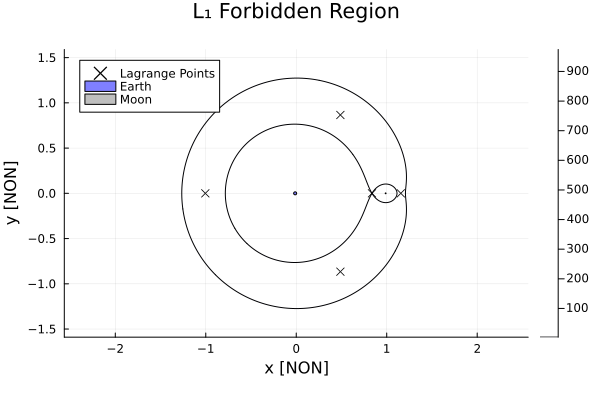

In [20]:
N = 1000 # Number of points to plot, square grid
X = Y = range(-1.5, 1.5, length=N) # Range of x and y values
f(x,y) = computeC([x,y,0],sys) # Function to plot
plot_fb = plot(sys); # Plot the system
contour!(plot_fb, X,Y,f,levels=[CLpts[1]],title="L₁ Forbidden Region") # Plot the forbidden region

### Zoom in to see the region near the secondary body

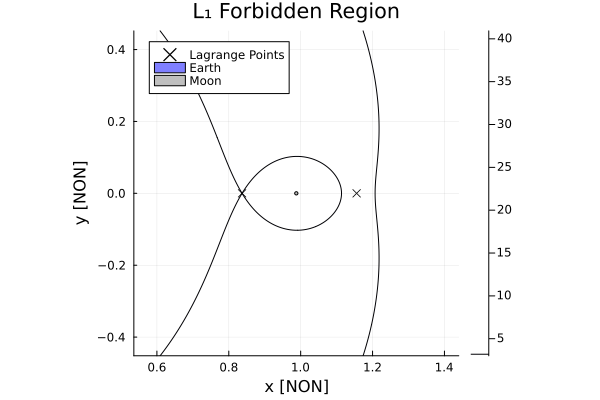

In [21]:
# Let's zoom in on the zero-velocity surface close to the secondary
N = 1000 # Number of points to plot, square grid
xlims,ylims = seczoom(sys,N=100) # Zoom in on the secondary body
X = range(xlims[1], xlims[2], length=N) # Range of x values
Y = range(ylims[1], ylims[2], length=N) # Range of y values
plot_fbzoom = plot(sys, xlims=xlims, ylims=ylims); # Plot the system
contour!(plot_fbzoom,X,Y,f,levels=[CLpts[1]],title="L₁ Forbidden Region") # Plot the forbidden region

We can see that the forbidden region comes to a point at L1. The only way to transit ballistically between the primary and secondary regions is through that point, which has zero velocity. This means transit is essentially impossible.

### Now what happens when we change the Jacobi constant to C(L₂)? 

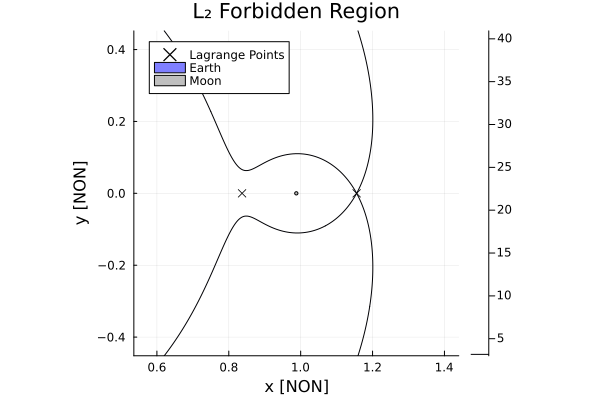

In [22]:
plot_fb = plot(sys, xlims=xlims, ylims=ylims); # Plot the system
contour!(plot_fb,X,Y,f,levels=[CLpts[2]],title="L₂ Forbidden Region") # Plot the forbidden region

There is now a large gap at L1 and many possible transit trajectories exist. The forbidden region comes to a point at L2, meaning transit between the secondary region and the exterior region is possible only through that one point (i.e. essentially impossible).

### Now what happens when we change the Jacobi constant to C(L₃)? 

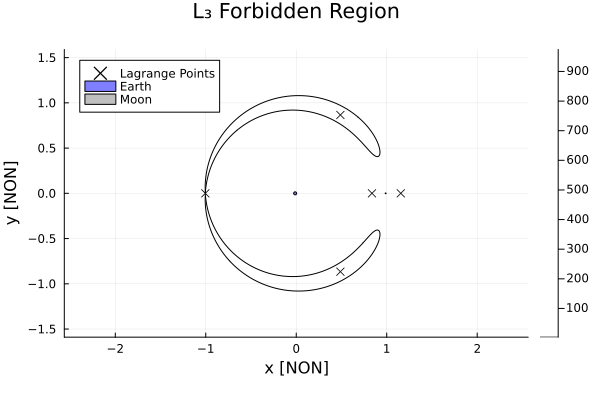

In [23]:
X = Y = range(-1.5, 1.5, length=N) # We'll have to zoom out again
plot_fb = plot(sys) # Plot the system
contour!(plot_fb,X,Y,f,levels=[CLpts[3]],title="L₃ Forbidden Region") # Plot the forbidden region

As you may have guessed, at C(L₄) = C(L₅), the forbidden region is gone entirely

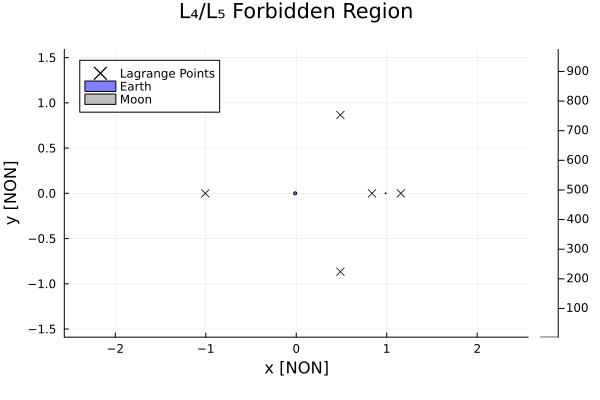

In [24]:
X = Y = range(-1.5, 1.5, length=N) # We'll have to zoom out again
plot_fb = plot(sys) # Plot the system
contour!(plot_fb,X,Y,f,levels=[CLpts[4]],title="L₄/L₅ Forbidden Region") # Plot the forbidden region